# Stable Diffusion with KerasCV and OpenVINO

<div class="alert alert-block alert-danger"> <b>Important note:</b> This notebook requires python >= 3.9. Please make sure that your environment fulfill to this requirement  before running it </div>

Stable Diffusion is a powerful, open-source text-to-image generation model. There are multiple implementations of this pipeline in different frameworks. Previously, we already considered how to convert and optimize [PyTorch Stable Diffusion using HuggingFace Diffusers library](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/notebooks/stable-diffusion-text-to-image/stable-diffusion-text-to-image.ipynb). In this tutorial, we consider how to convert and run [Stable Diffusion from KerasCV](https://www.tensorflow.org/tutorials/generative/generate_images_with_stable_diffusion) that employs graph mode execution, which enhances performance by leveraging graph optimization and enabling parallelism and in the same time maintains a user-friendly interface for image generation.

#### Table of contents:
 - [Prerequisites](#Prerequisites)
 - [Convert Stable Diffusion Pipeline models to OpenVINO](#Convert-Stable-Diffusion-Pipeline-models-to-OpenVINO)
    - [Convert text encoder](#Convert-text-encoder)
    - [Convert diffusion model](#Convert-diffusion-model)
    - [Convert decoder](#Convert-decoder)
 - [Stable Diffusion Pipeline with OpenVINO](#Stable-Diffusion-Pipeline-with-OpenVINO)
 - [Interactive Demo](#Interactive-Demo)

### Prerequisites
[back to top ⬆️](#Table-of-contents:)

In [ ]:
import platform

%pip uninstall -q -y openvino openvino-dev openvino-nightly
%pip install -q "tensorflow-macos>=2.15; sys_platform == 'darwin' and platform_machine == 'arm64' and python_version > '3.8'" # macOS M1 and M2
%pip install -q "tensorflow>=2.15; sys_platform == 'darwin' and platform_machine != 'arm64' and python_version > '3.8'" # macOS x86
%pip install -q "tensorflow>=2.15; sys_platform != 'darwin' and python_version > '3.8'"
%pip install -q keras-cv tf_keras numpy openvino-nightly "gradio>=4.19"


if platform.system() != "Windows":
    %pip install -q "matplotlib>=3.4"
else:
    %pip install -q "matplotlib>=3.4,<3.7"

### Convert Stable Diffusion Pipeline models to OpenVINO

[back to top ⬆️](#Table-of-contents:)

Stable Diffusion consists of three parts:

- A text encoder, which turns your prompt into a latent vector.
- A diffusion model, which repeatedly "denoises" a 64x64 latent image patch.
- A decoder, which turns the final 64x64 latent patch into a higher-resolution 512x512 image.


![workflow-diagram](https://github.com/openvinotoolkit/openvino_notebooks/assets/67365453/2d7950a3-5bad-4670-897b-4d5327278feb)

Let us convert each model to OpenVINO format.

Import required modules and set constants

In [ ]:
import os

os.environ["TF_USE_LEGACY_KERAS"] = "1"

import keras_cv
import openvino as ov
import numpy as np
from pathlib import Path

IMAGE_WIDTH = 512
IMAGE_HEIGHT = 512
BATCH_SIZE = 1
MAX_PROMPT_LENGTH = 77


OV_TEXT_ENCODER_MODEL_PATH = Path("models/ov_text_encoder_model.xml")
OV_DIFFUSION_MODEL_PATH = Path("models/ov_diffusion_model.xml")
OV_DECODER_MODEL_PATH = Path("models/ov_decoder_model.xml")

Create KerasCV Stable Diffusion pipeline

In [2]:
pipeline = keras_cv.models.StableDiffusion(img_width=IMAGE_WIDTH, img_height=IMAGE_HEIGHT)

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


#### Convert text encoder

[back to top ⬆️](#Table-of-contents:)

Text encoder has 2 inputs: `tokens` and `positions`. Specify inputs shapes and provide example data for model tracing.

In [3]:
text_encoder_input = {
    "tokens": (BATCH_SIZE, MAX_PROMPT_LENGTH),
    "positions": (BATCH_SIZE, MAX_PROMPT_LENGTH),
}

text_encoder_example_input = (
    np.random.randint(len(pipeline.tokenizer.vocab), size=(1, MAX_PROMPT_LENGTH)),
    np.expand_dims(np.arange(MAX_PROMPT_LENGTH), axis=0),
)

ov_text_encoder = ov.convert_model(
    pipeline.text_encoder,
    example_input=text_encoder_example_input,
    input=text_encoder_input,
)
ov.save_model(ov_text_encoder, OV_TEXT_ENCODER_MODEL_PATH)
del ov_text_encoder

#### Convert diffusion model

[back to top ⬆️](#Table-of-contents:)

Diffusion model has 3 inputs `latent`, `timestep_embedding` and `context`. Specify inputs shapes and provide example data for model tracing.

In [4]:
diffusion_model_input = {
    "latent": [BATCH_SIZE, pipeline.img_height // 8, pipeline.img_width // 8, 4],
    "timestep_embedding": [BATCH_SIZE, 320],
    "context": [BATCH_SIZE, MAX_PROMPT_LENGTH, 768],
}

diffusion_model_example_input = (
    np.random.random(size=(1, pipeline.img_height // 8, pipeline.img_width // 8, 4)),
    np.random.random(size=(1, 320)),
    np.random.random(size=(1, MAX_PROMPT_LENGTH, 768)),
)

ov_diffusion_model = ov.convert_model(
    pipeline.diffusion_model,
    input=diffusion_model_input,
    example_input=diffusion_model_example_input,
)
ov.save_model(ov_diffusion_model, OV_DIFFUSION_MODEL_PATH)
del ov_diffusion_model

#### Convert decoder

[back to top ⬆️](#Table-of-contents:)

Decoder has 1 input for image latents. Specify input shapes and provide example data for model tracing.

In [5]:
decoder_input = [BATCH_SIZE, pipeline.img_height // 8, pipeline.img_width // 8, 4]

decoder_example_input = np.random.random(size=(1, pipeline.img_height // 8, pipeline.img_width // 8, 4))

ov_decoder = ov.convert_model(pipeline.decoder, input=decoder_input, example_input=decoder_example_input)
ov.save_model(ov_decoder, OV_DECODER_MODEL_PATH)
del ov_decoder

In [6]:
# free memory
import gc

del pipeline
gc.collect()

64354

### Stable Diffusion Pipeline with OpenVINO

[back to top ⬆️](#Table-of-contents:)

Let's take [KerasCV pipeline implementation](https://github.com/keras-team/keras-cv/tree/master/keras_cv/models/stable_diffusion) and replace original models with OpenVINO ones.

In [7]:
"""
Credits:

- Original implementation:
  https://github.com/CompVis/stable-diffusion
- Initial TF/Keras port:
  https://github.com/divamgupta/stable-diffusion-tensorflow
- Keras CV implementation:
  https://github.com/keras-team/keras-cv/tree/master/keras_cv/models/stable_diffusion
"""

import math
import tf_keras as keras
import numpy as np
import tensorflow as tf

from constants import UNCONDITIONAL_TOKENS, ALPHAS_CUMPROD
from keras_cv.models.stable_diffusion import SimpleTokenizer


class StableDiffusion:
    def __init__(self, text_encoder, diffusion_model, decoder):
        # UNet requires multiples of 2**7 = 128
        img_height = round(IMAGE_HEIGHT / 128) * 128
        img_width = round(IMAGE_WIDTH / 128) * 128
        self.img_height = img_height
        self.img_width = img_width

        self._tokenizer = None
        self._text_encoder = text_encoder
        self._diffusion_model = diffusion_model
        self._decoder = decoder

        print(
            "By using this model checkpoint, you acknowledge that its usage is "
            "subject to the terms of the CreativeML Open RAIL-M license at "
            "https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE"
        )

    def text_to_image(
        self,
        prompt,
        negative_prompt=None,
        num_steps=50,
        unconditional_guidance_scale=7.5,
        seed=None,
    ):
        encoded_text = self.encode_text(prompt)

        return self._generate_image(
            encoded_text,
            negative_prompt=negative_prompt,
            batch_size=BATCH_SIZE,
            num_steps=num_steps,
            unconditional_guidance_scale=unconditional_guidance_scale,
            seed=seed,
        )

    def encode_text(self, prompt):
        # Tokenize prompt (i.e. starting context)
        inputs = self.tokenizer.encode(prompt)
        if len(inputs) > MAX_PROMPT_LENGTH:
            raise ValueError(f"Prompt is too long (should be <= {MAX_PROMPT_LENGTH} tokens)")

        phrase = inputs + [49407] * (MAX_PROMPT_LENGTH - len(inputs))

        phrase = tf.convert_to_tensor([phrase], dtype="int32")

        return self.text_encoder({"tokens": phrase, "positions": self._get_pos_ids()})

    def text_encoder(self, args):
        return self._call_ov_model(self._text_encoder, args)

    def diffusion_model(self, args):
        return self._call_ov_model(self._diffusion_model, args)

    def decoder(self, args):
        return self._call_ov_model(self._decoder, args)

    def _generate_image(
        self,
        encoded_text,
        negative_prompt=None,
        batch_size=BATCH_SIZE,
        num_steps=50,
        unconditional_guidance_scale=7.5,
        diffusion_noise=None,
        seed=None,
    ):
        if diffusion_noise is not None and seed is not None:
            raise ValueError(
                "`diffusion_noise` and `seed` should not both be passed to "
                "`generate_image`. `seed` is only used to generate diffusion "
                "noise when it's not already user-specified."
            )

        context = self._expand_tensor(encoded_text, batch_size)

        if negative_prompt is None:
            unconditional_context = np.repeat(self._get_unconditional_context(), batch_size, axis=0)
        else:
            unconditional_context = self.encode_text(negative_prompt)
            unconditional_context = self._expand_tensor(unconditional_context, batch_size)

        if diffusion_noise is not None:
            diffusion_noise = np.squeeze(diffusion_noise)

            if len(np.shape(diffusion_noise)) == 3:
                diffusion_noise = np.repeat(np.expand_dims(diffusion_noise, axis=0), batch_size, axis=0)
            latent = diffusion_noise
        else:
            latent = self._get_initial_diffusion_noise(batch_size, seed)

        # Iterative reverse diffusion stage
        num_timesteps = 1000
        ratio = (num_timesteps - 1) / (num_steps - 1)
        timesteps = (np.arange(0, num_steps) * ratio).round().astype(np.int64)

        alphas, alphas_prev = self._get_initial_alphas(timesteps)
        progbar = keras.utils.Progbar(len(timesteps))
        iteration = 0
        for index, timestep in list(enumerate(timesteps))[::-1]:
            latent_prev = latent  # Set aside the previous latent vector
            t_emb = self._get_timestep_embedding(timestep, batch_size)

            unconditional_latent = self.diffusion_model(
                {
                    "latent": latent,
                    "timestep_embedding": t_emb,
                    "context": unconditional_context,
                }
            )

            latent = self.diffusion_model(
                {
                    "latent": latent,
                    "timestep_embedding": t_emb,
                    "context": context,
                }
            )

            latent = np.array(unconditional_latent + unconditional_guidance_scale * (latent - unconditional_latent))
            a_t, a_prev = alphas[index], alphas_prev[index]
            # Keras backend array need to cast explicitly
            target_dtype = latent_prev.dtype
            latent = np.array(latent, target_dtype)
            pred_x0 = (latent_prev - math.sqrt(1 - a_t) * latent) / math.sqrt(a_t)
            latent = np.array(latent) * math.sqrt(1.0 - a_prev) + math.sqrt(a_prev) * pred_x0
            iteration += 1
            progbar.update(iteration)

        # Decoding stage
        decoded = self.decoder(latent)

        decoded = ((decoded + 1) / 2) * 255
        return np.clip(decoded, 0, 255).astype("uint8")

    def _get_unconditional_context(self):
        unconditional_tokens = tf.convert_to_tensor([UNCONDITIONAL_TOKENS], dtype="int32")

        unconditional_context = self.text_encoder({"tokens": unconditional_tokens, "positions": self._get_pos_ids()})

        return unconditional_context

    def _expand_tensor(self, text_embedding, batch_size):
        text_embedding = np.squeeze(text_embedding)
        if len(text_embedding.shape) == 2:
            text_embedding = np.repeat(np.expand_dims(text_embedding, axis=0), batch_size, axis=0)
        return text_embedding

    @property
    def tokenizer(self):
        if self._tokenizer is None:
            self._tokenizer = SimpleTokenizer()
        return self._tokenizer

    def _call_ov_model(self, ov_model, args):
        return ov_model(args)[ov_model.output(0)]

    def _get_timestep_embedding(self, timestep, batch_size, dim=320, max_period=10000):
        half = dim // 2
        range = np.array(np.arange(0, half), "float32")
        freqs = np.exp(-math.log(max_period) * range / half)
        args = tf.convert_to_tensor([timestep], dtype="float32") * freqs
        embedding = np.concatenate([np.cos(args), np.sin(args)], 0)
        embedding = np.reshape(embedding, [1, -1])
        return np.repeat(embedding, batch_size, axis=0)

    def _get_initial_alphas(self, timesteps):
        alphas = [ALPHAS_CUMPROD[t] for t in timesteps]
        alphas_prev = [1.0] + alphas[:-1]

        return alphas, alphas_prev

    def _get_initial_diffusion_noise(self, batch_size, seed):
        np.random.seed(seed)
        return np.random.normal(
            size=(batch_size, self.img_height // 8, self.img_width // 8, 4),
        )

    @staticmethod
    def _get_pos_ids():
        return np.expand_dims(np.arange(MAX_PROMPT_LENGTH, dtype="int32"), 0)

Select device from dropdown list for running inference using OpenVINO.

In [ ]:
import ipywidgets as widgets
import openvino as ov

device = widgets.Dropdown(
    options=ov.Core().available_devices + ["AUTO"],
    value="AUTO",
    description="Device:",
    disabled=False,
)

device

Read and compile pipeline models using selected device.

In [9]:
core = ov.Core()
ov_text_encoder = core.compile_model(OV_TEXT_ENCODER_MODEL_PATH, device.value)
ov_diffusion_model = core.compile_model(OV_DIFFUSION_MODEL_PATH, device.value)
ov_decoder = core.compile_model(OV_DECODER_MODEL_PATH, device.value)

In [10]:
import matplotlib.pyplot as plt


def plot_images(images):
    plt.figure(figsize=(8 * len(images), 10))
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")

Create and run Stable Diffusion pipeline using OpenVINO models.

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE
50/50 [==============================] - 129s 3s/step


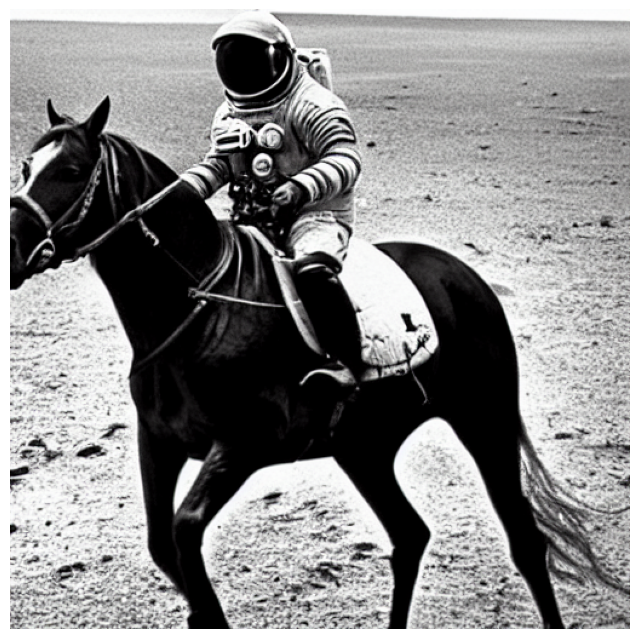

In [11]:
ov_pipeline = StableDiffusion(text_encoder=ov_text_encoder, diffusion_model=ov_diffusion_model, decoder=ov_decoder)

images = ov_pipeline.text_to_image("photograph of an astronaut riding a horse", num_steps=50, seed=80)

plot_images(images)

### Interactive Demo

[back to top ⬆️](#Table-of-contents:)

In [ ]:
import gradio as gr


def generate(text, seed, steps):
    return ov_pipeline.text_to_image(text, num_steps=steps, seed=seed)[0]


demo = gr.Interface(
    generate,
    [
        gr.Textbox(lines=3, label="Text"),
        gr.Slider(0, 10000000, value=45, label="Seed"),
        gr.Slider(1, 50, value=25, step=1, label="Steps"),
    ],
    gr.Image(label="Result"),
    examples=[
        ["photograph of an astronaut riding a horse", 80, 25],
        ["photograph of a cat", 45, 25],
    ],
    allow_flagging="never",
)

try:
    demo.launch(debug=True, height=1000)
except Exception:
    demo.launch(share=True, debug=True, height=1000)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/